$$\require{mhchem}$$       

# Nonisothermal PFR [2 pts]

Complete the final example from 11/19 (PFR with counter-flow heat exchanger) with your choice of solver (BVP_nl or solve_bvp from scipy). Comment on any numerical troubles or issues you ran into along the way.

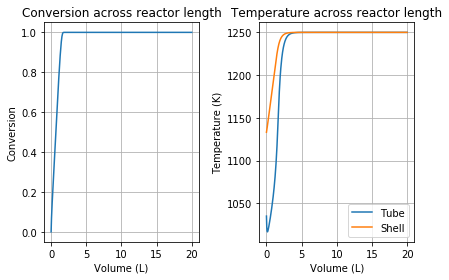

In [35]:
'Assumption: At V = 20L, the temperature of the heat transfer fluid entering is 1250 K.'

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

Fa0 = 0.0376      # mol/s
Ca0 = 0.0188      # mol / L

v0 = Fa0 / Ca0    # initial volumetric flow
Ft0 = Fa0

T0 = 1035.0       # K

Hrxn_298 = 80.77  # kJ/mol at 298K
Cpa = 0.1630      # kJ/mol/K
Cpb = 0.083
Cpc = 0.071

Tshell0 = 1250.0    # ambient heat exchanger temperature
Ua = 0.0165         # overall heat transfer coefficient
mdot = 1.0          # mol/s coolant flow rate
Cpcoolant = 0.0345  # Heat capacity of coolant


def pfr(V, Y):
    Fa, T, Tshell = Y
    extent = (Fa - Fa0) / (-1.0)
    Xi = extent
    Fb = Xi
    Fc = Xi

    Ft = Fa + Fb + Fc

    v = v0 * Ft / Ft0 * T / T0

    k = np.exp(34.3 - 34222.0 / T)
    Ca = Fa / v
    r = k * Ca
    ra = -r
    Hrxn = Hrxn_298 + (Cpb + Cpc - Cpa) * (T - 298.0)
    dFadV = ra
    Qdot = Ua * (Tshell - T)
    dTdV = (-Hrxn * r + Qdot) / (Fa * Cpa + Fb * Cpb + Fc * Cpc)
    dTshelldV = Qdot / (mdot * Cpcoolant)

    return [dFadV, dTdV, dTshelldV]

def bc(L,U):
    Fal, Tl, Tsl = L
    Fau, Tu, Tsu = U
    return [Fal- Fa0, Tl - T0, Tsu - Tshell0]

Vn = np.array([0,0.2, 3.2,  20])
Tn = np.array([1035,1017, 1250,  1250])
Tshelln = np.array([1133,1144, 1250,  1250])
Fan = np.array([3.76e-2,3.06e-2, 1.25e-12,  0])

Tg = interp1d(Vn, Tn)
Tsg = interp1d(Vn, Tshelln)
Fag = interp1d(Vn, Fan)
Vspan = np.linspace(0,20)

Guess_ = np.array([Fag(Vspan), Tg(Vspan), Tsg(Vspan)])

sol = solve_bvp(pfr, bc, Vspan, Guess_)

V = sol.x

Fa = sol.y[0]
T = sol.y[1]
Tshell = sol.y[2]
X = ((Fa - Fa0) * (-1) / Fa0)

plt.subplot(1, 2, 1)
plt.plot(V, X)
plt.xlabel('Volume (L)')
plt.ylabel('Conversion')
plt.title('Conversion across reactor length')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(V, T, label='Tube')
plt.plot(V, Tshell, label='Shell')
plt.xlabel('Volume (L)')
plt.ylabel('Temperature (K)')
plt.title('Temperature across reactor length')
plt.legend(loc='best')
plt.tight_layout()
plt.grid()
plt.show()

*ISSUES ENCOUUNTERED*

This boundary value problem's solution is very sensitive to the initial guess taken. 
This can be improved by solving the above using linear algebra

# Non-isothermal batch reactor design [8 pts]

The exothermic elementary liquid phase reaction
\begin{align}
\ce{A + B <->[k,K] C + D}\\
\end{align}
is carried out in a batch reactor with a cooling coil to keep the reactor isothermal at 40 C. The reactor is initially charged with equal concentrations of A and B and no C or D, $C_{A0}=C_{B0}=2$mol/L.  

$k=0.1$ L/mol/min at 40 C, $K=2$ at 40 C

$\Delta H_R=-20$ kcal/mol A at 40 C

Partial molar heat capacities $C_{pA}=C_{pB}=C_{pC}=C_{pD}=20$cal/mol

Activation energy for the reaction $E_a=1000 cal/mol/K$. 

Reactor volume 1200 L

Energy Balance:

\begin{multline}
\sum_j \overline{H}_j \frac{dn_j}{dt} = + \dot{Q}
\end{multline}

#### How long does it take to reach 50% conversion? Also show a plot of concentration of all species vs time.

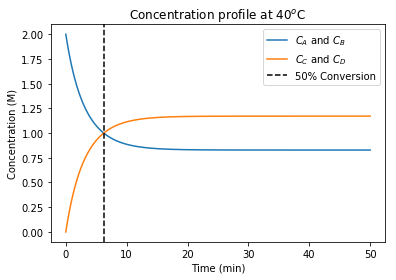

The reaction reaches 50% conversion in time 6.23 min


In [40]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Ea=1000 #cal/mol/K 
V = 1200 #L
k =0.1  #L/mol/min at 40 C
K = 2 #at 40 C
CpA = CpB = CpC = CpD = 20 #cal/mol
CA0 = CB0 = 2 #mol/L
CC0 = CD0 = 0 #mol/L
Hr= -20  #kcal/mol A at 40 C

def batch(t, Ca):
    Cb = Ca
    Cc = Cd = CA0 - Ca
    r = k * (Ca*Cb - Cc*Cd / K)
    
    dCadt = -r
    return dCadt

def x50(t, Ca):
    return Ca - 0.5 * CA0

x50.terminal = False

tspan = [0,50]

sol = solve_ivp(batch, tspan, np.array([CA0]), max_step = 0.1, events = x50, dense_output=True)
t = sol.t
te = sol.t_events

CA = CB = sol.y[0]
CC = CD = CA0 - CA

plt.plot(t, CA.T, label = '$C_A$ and $C_B$')
plt.plot(t, CC.T, label = '$C_C$ and $C_D$')
plt.axvline(te, color = 'k', linestyle = '--', label = '50% Conversion')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.title('Concentration profile at $40^o$C')
plt.legend()
plt.show()

print(f'The reaction reaches 50% conversion in time {te[0][0]:1.2f} min')

#### What is the total amount of heat (kcal) that must be removed by the cooling coil when the conversion is reached?

In [41]:
CA_50 = sol.sol(te[0][0])
dCa = (CA[0] - CA_50)[0]
dNa = dCa * V
Q = - Hr * dNa
print(f'The total amount of heat that must be removed by the cooling coil when 50% conversion is reached is {Q:1.1f} kcal.')

The total amount of heat that must be removed by the cooling coil when 50% conversion is reached is 24000.0 kcal.


#### What is the maximum rate at which heat must be removed by the cooling coil, and at what time does this occur?

In [49]:
rate = k * (CA*CB - CC*CD / K)

Q = - Hr * rate * V # '-' sign since it is the energy being removed
m = np.argmax(Q)

print(f'The maximum rate at which heat must be removed by the cooling coil is\
 {Q[m]:1.3f} kcal and it occurs at {t[m]:1.0f} th minute.')

The maximum rate at which heat must be removed by the cooling coil is 9600.000 kcal and it occurs at 0 th minute.


#### Now consider a non-isothermal version of this reactor.  There is a cooling bath around the reactor with a total heat transfer coefficient $Ua=300$ kcal/*K*/min. The reactor starts at 40 C  What is the maximum temperature $T_0$ that you can keep the cooling bath such that the temperature in the batch reactor rises no higher than 60C?



Energy Balance:

\begin{align}
\sum N_j C_{p,j} \frac{dT}{dt} = - \Delta H_{rx} r V + Ua(Tc - T)
\end{align}


In [38]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Ea=1000 #cal/mol/K 
R = 1.987       # cal/mol/K
V = 1200 #L
k0 =0.1  #L/mol/min at 40 C
K0 = 2 #at 40 C
CpA = CpB = CpC = CpD = 20 #cal/mol/K
CA0 = CB0 = 2 #mol/L
Hr= -20  #kcal/mol A at 40 C
Ua = 300  # kcal/K/min
T0 = 273.15 + 40

def TCool(Tc):
    def noniso_batch(t, Y):
        Ca, T = Y

        k = k0 * np.exp(-Ea/R * (1.0/T - 1.0/T0))
        K = K0 * np.exp(-1000*Hr / R * (1/T - 1/T0))
        # Mass Balance
        Cb = Ca
        Cc = Cd = CA0 - Ca
        r = k * (Ca*Cb - Cc*Cd / K)  # M/min
        dCadt = -r

        # Energy Balance
        NCp = (Ca+Cb+Cc+Cd) * CpA * V # Since all Cp are equal

        dTdt = (- Hr * r * V + Ua * (Tc - T)) / NCp * 1000  # 1000 since NCp is converted from cal to kcal 

        return [dCadt, dTdt]

    tspan = [0,50]

    solTc = solve_ivp(noniso_batch, tspan, np.array([CA0, T0]), max_step = 0.1, dense_output=True)
    t = solTc.t
    CA = solTc.y[0]
    T = solTc.y[1]
    Tmax = max(T)
    
    return Tmax - (273.15 + 60)

ans = fsolve(TCool, 300)
print(f'The maximum cooling temperature at which batch can be operated is at: {ans[0]:1.3f} K.')

The maximum cooling temperature at which batch can be operated is at: 307.754 K.


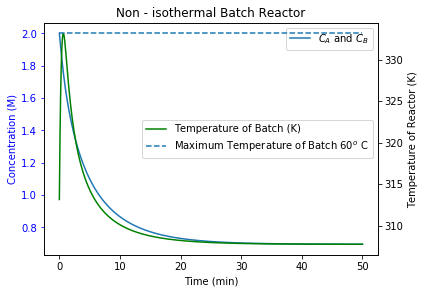

In [39]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Ea=1000 #cal/mol/K 
R = 1.987       # cal/mol/K
V = 1200 #L
k0 =0.1  #L/mol/min at 40 C
K0 = 2 #at 40 C
CpA = CpB = CpC = CpD = 20 #cal/mol/K
CA0 = CB0 = 2 #mol/L
Hr= -20  #kcal/mol A at 40 C
Tc = 308 # K
Ua = 300  # kcal/L/min
T0 = 273.15 + 40
Tc = ans[0]

def noniso_batch(t, Y):
    Ca, T = Y

    k = k0 * np.exp(-Ea/R * (1.0/T - 1.0/T0))
    K = K0 * np.exp(-1000*Hr / R * (1/T - 1/T0))
    # Mass Balance
    Cb = Ca
    Cc = Cd = CA0 - Ca
    r = k * (Ca*Cb - Cc*Cd / K)  # M/min
    dCadt = -r

    # Energy Balance
    NCp = (Ca+Cb+Cc+Cd) * CpA * V # Since all Cp are equal

    dTdt = (- Hr * r * V + Ua * (Tc - T)) / NCp * 1000  # 1000 since NCp is converted from cal to kcal 

    return [dCadt, dTdt]

tspan = [0,50]

sol2 = solve_ivp(noniso_batch, tspan, np.array([CA0, T0]), max_step = 0.1, dense_output=True)
t = sol2.t
CA = sol2.y[0]
T = sol2.y[1]
Tmax = max(T)

fig, ax1 = plt.subplots()
ax1.plot(t, CA.T, label = '$C_A$ and $C_B$')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Concentration (M)', color='b')
ax1.tick_params('y', colors='b')
plt.legend(loc= 'best')

ax2 = ax1.twinx()
ax2.plot(t, T.T, 'g', label = 'Temperature of Batch (K)')
ax2.plot(t, Tmax*np.ones(len(t)), '--', label = 'Maximum Temperature of Batch $60^o$ C')
ax2.set_ylabel('Temperature of Reactor (K)', color='k')
ax2.tick_params('y', colors='k')

plt.legend(loc= 'center right')
fig.tight_layout()
plt.title('Non - isothermal Batch Reactor')
plt.show()

# PBR with internal mass transfer and heat drops [8 pts]

You have a isomerization catalytic reactor with the following kinetics:
\begin{align*}
\ce{A + S <->[K_A] AS}\\
\ce{AS ->[k] BS}\\
\ce{BS -> B + S}
\end{align*}
The surface step is limiting and you derive the following rate law:
\begin{align*}
r= k \overline{c}_m \frac{K_A c_A}{1 + K_A c_A}
\end{align*}
The reactor is a 500 L CSTR with 5 kg of catalyst particles.  The catalyst particles are 20 mm diameter, the rate constant for the surface step is 100/s/g$_{cat}$, the activation energy for the surface step is $20$ kcal/mol, the heat of reaction for the first adsorption step is $\Delta H_R=-5$kcal/mol (assume temperature independent), the heat of reaction for the full reaction \ce{A->B} is -10 kcal/mol, and the equilibrium coefficient at 200 C is 2. The specific heat of A and B are both 10 cal/molK. The diffusion coefficient at 200 C for A in the particle is 0.1 cm$^2/s$ at 200 C and scales with temperature as $D=D_0(T/T0)^{3/2}$. The pressure drop in the reactor is negligible. The reactor is fed with $4 mol/L$ A at 1 L/s at 200 C. The catalyst site density is $C_m=10^{-2}$ mol/gcat. The reactor is adiabatic (no heat transfer). 

You may assume that the solution for a sphere applies $ \eta = \frac{1}{\Phi}  \left [\frac{1}{\tanh 3 \Phi} - \frac{1}{3 \Phi} \right]$, using the correct $\Phi$ for this problem / rate law.

#### Calculate the exit concentration of the CSTR for an inlet feed at 200 C

Energy Balance:

\begin{equation}
\sum N_j C_{p,j} \frac{dT}{dt} = \sum F_{j0} C_{p,j} (T_0 - T) - \Delta H_{rx} r V + \dot{Q}
\end{equation}

In [72]:
import numpy as np
from scipy.optimize import minimize

CA0 = 4 # M
v0 = 1 # L/s
V = 500 # L
W = 5 # kg
d = 20 # mm
k0 = 100 # /s/g cat
Ea = 20 # kcal/mol
R = 1.987 * 1e-3  # kcal/mol/K
dHR = -5 # kcal/mol for 1st adsorption rxn
dHrxn = 5 # kcal/mol for complete rxn
Cp = 10 # cal/mol/K
K0 = 2 # at 200 C
D0 = 0.1 # cm^2/s
Cm = 0.01 # mol/gcat
a = d / 6 * 0.1  # cm

FA0 = CA0 * v0

def CSTR(Y, T0):
    CA, T = Y
    v = v0
    k = k0 * np.exp(-Ea / R * (1/T - 1/T0))
    # Assuming equi cons mentioned is for Ka
    Ka = K0 * np.exp(-dHR / R * (1/T - 1/T0))
    
    # Ideal rate
    
    D = D0 * (T/T0)**1.5
    Na = CA * V
    IR = k * Cm * (Ka * CA) / (Ka * CA + 1)  # Units: M/s /g-cat^2 ?
    
    # Actual rate
    phi = Ka * CA
    thiele_wiggle = np.sqrt(k * Cm * Ka * a**2 / D)

    thiele_mod = (phi / (1+phi)) * thiele_wiggle / np.sqrt(2 * (phi - np.log(1+phi)))

    eta = 1 / thiele_mod * (1/np.tanh(3 * thiele_mod) - 1/(3 * thiele_mod))
    r = eta * IR
    

    # Material Balance
    tau = V / v
    dNadt = FA0 - CA * v  - r * W * 1000 
    
    # Energy Balance
    Fa = Na / tau
    Fb = FA0 - Fa
    Nb = Fb * tau
    
    NCp = Cp * (Na + Nb) * 1e-3 # kcal/K
    dTdt = ((CA0 * v0) * Cp/1000 * (T0 - T) - dHrxn * r * W * 1000) / NCp

    return np.array([dNadt, dTdt])

ans = fsolve(CSTR, [3,T0], args = 200+273.15)

print(f'The exit concentration of A is {ans[0]:1.2f} M at temperature of {ans[1]:1.2f} K.')

The exit concentration of A is 2.93 M at temperature of 338.92 K.


 #### Calculate the exit concentration as a function of temperature of the inlet feed

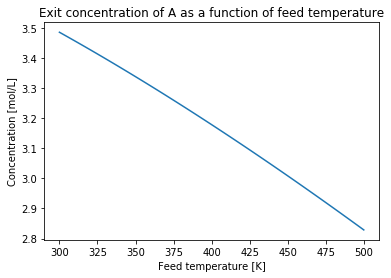

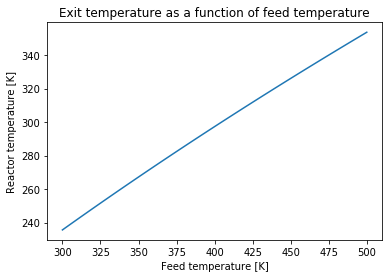

In [73]:
import matplotlib.pyplot as plt

Ca = []
T = []
Trange = np.linspace(300, 500, 51)

for T0 in Trange:
    ans = fsolve(CSTR, [3,T0], args = T0)
    Ca.append(ans[0])
    T.append(ans[1])

plt.plot(Trange, Ca)
plt.ylabel('Concentration [mol/L]')
plt.xlabel('Feed temperature [K]')
plt.title('Exit concentration of A as a function of feed temperature')
plt.show()

plt.plot(Trange, T)
plt.xlabel('Feed temperature [K]')
plt.ylabel('Reactor temperature [K]')
plt.title('Exit temperature as a function of feed temperature');


# Piazza (2 pts)

This week, either submit a question or answer a question for two points. Post the link to your question or answer

https://piazza.com/class/jl5aabbtksz62s?cid=554